This script performs several setps of time series analyis

First section: Order selection for ARIMAX model based on lowest AIC and BIC

Second section: Testing for model performance improvement in terms of MAPE, RMSE, and Accuracy in predicting the right return sign.

Note that the aim of our research is not to identify multicollinearity, endogeneity. The purpose is to test whether the predictive power of classical ARMAX models can be improved by including our sentiment score as an exogenous variable.


In [648]:
import pandas as pd
import numpy as np
import pickle
import random
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


import warnings
warnings.filterwarnings('ignore')
random.seed(42)

df = pd.read_csv("./tsdata/modeldata.csv", index_col='Date', parse_dates=True)
df.index.freq = "MS"
df['msci_lag1'] = df['msci'].shift(1)
df['sentiment_lag1'] = df['sentiment'].shift(1)
df = df.dropna()
print(df.head())

             returns      msci  sentiment  msci_lag1  sentiment_lag1
Date                                                                
2012-02-01  0.146806  0.011673   0.148969   0.198444       -0.008786
2012-03-01  0.083715  0.035019  -0.140396   0.011673        0.148969
2012-04-01  0.001341  0.007782  -0.019119   0.035019       -0.140396
2012-05-01 -0.047849  0.112840  -0.070178   0.007782       -0.019119
2012-06-01 -0.005572 -0.237354   0.241201   0.112840       -0.070178


In [631]:
#Creating data sets for train and test, provide different data sets for different exo vars
endtrain = "2021-01-01"
starttest = '2021-02-01'
endtest = '2021-12-01'

train = df[:endtrain]
test = df[starttest:endtest]

y = train['returns']
X_msci = train[["msci_lag1"]]
X_sent = train[["sentiment_lag1"]]
X_both = train[["msci_lag1", "sentiment_lag1"]]


ytest = test["returns"]

Xmsci_test = test[["msci_lag1"]]
Xsent_test = test[["sentiment_lag1"]]
Xboth_test = test[["msci_lag1", "sentiment_lag1"]]


In [632]:
#function for MAPE
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

#function for RMSE
def rmse(actual, pred):
    return np.sqrt(mean_squared_error(actual, pred))

#function to evaluate the ARMAX model for a given order (p, 0, q)
def evaluateModel(data, exog, order, actual, exogtest):
    model = SARIMAX(data, exog=exog, order=(order[0], 0, order[1]), enforce_stationarity=True, enforce_invertibility=True)
    model_fit = model.fit(disp=False, maxiter = 300)
    prediction = model_fit.get_forecast(steps=len(ytest), exog=exogtest).predicted_mean
    MAPE_f = mape(actual, prediction)
    RMSE_f = rmse(actual, prediction)
    return order, model_fit.aic, model_fit.bic, MAPE_f, RMSE_f
"""
#set range for considered (p, q) order
orders = [(p, q) for p in range(5) for q in range(5) if (p, q) != (0, 0)]

results_base = []
results_msci = []
results_sent = []
results_both = []

#Base model
for order in orders:
    try:
        order, aic, bic, MAPE_base, RMSE_base = evaluateModel(y, None, order, ytest, None)
        results_base.append([order, aic, bic, MAPE_base, RMSE_base])
    except Exception as e:
        print(f"Order {order} for base model failed: {e}")


#Including MSCI
for order in orders:
    try:
        order, aic_msci, bic_msci, MAPE_msci, RMSE_msci = evaluateModel(y, X_msci, order, ytest, Xmsci_test)
        results_msci.append([order, aic_msci, bic_msci, MAPE_msci, RMSE_msci])
    except Exception as e:
        print(f"Order {order} with msci failed: {e}")

#Including own sentiment score
for order in orders:
    try:
        order, aic_sent, bic_sent, MAPE_sent, RMSE_sent = evaluateModel(y, X_sent, order, ytest, Xsent_test)
        results_sent.append([order, aic_sent, bic_sent, MAPE_sent, RMSE_sent])
    except Exception as e:
        print(f"Order {order} with sentiment failed: {e}")


#Including both scores
for order in orders:
    try:
        order, aic_both, bic_both, MAPE_both, RMSE_both = evaluateModel(y, X_both, order, ytest, Xboth_test)
        results_both.append([order, aic_both, bic_both, MAPE_both, RMSE_both])
    except Exception as e:
        print(f"Order {order} with both variables failed: {e}")

#store results in separate DFs
df_base = pd.DataFrame(results_base, columns=['Order', 'AIC', 'BIC', "MAPE", "RMSE"])
df_msci = pd.DataFrame(results_msci, columns=['Order', 'AIC', 'BIC', "MAPE", "RMSE"])
df_sent = pd.DataFrame(results_sent, columns=['Order', 'AIC', 'BIC', "MAPE", "RMSE"])
df_both = pd.DataFrame(results_both, columns=['Order', 'AIC', 'BIC', "MAPE", "RMSE"])

#inspect results
print(df_base)
print(df_msci)
print(df_sent)
print(df_both)
"""

'\n#set range for considered (p, q) order\norders = [(p, q) for p in range(5) for q in range(5) if (p, q) != (0, 0)]\n\nresults_base = []\nresults_msci = []\nresults_sent = []\nresults_both = []\n\n#Base model\nfor order in orders:\n    try:\n        order, aic, bic, MAPE_base, RMSE_base = evaluateModel(y, None, order, ytest, None)\n        results_base.append([order, aic, bic, MAPE_base, RMSE_base])\n    except Exception as e:\n        print(f"Order {order} for base model failed: {e}")\n\n\n#Including MSCI\nfor order in orders:\n    try:\n        order, aic_msci, bic_msci, MAPE_msci, RMSE_msci = evaluateModel(y, X_msci, order, ytest, Xmsci_test)\n        results_msci.append([order, aic_msci, bic_msci, MAPE_msci, RMSE_msci])\n    except Exception as e:\n        print(f"Order {order} with msci failed: {e}")\n\n#Including own sentiment score\nfor order in orders:\n    try:\n        order, aic_sent, bic_sent, MAPE_sent, RMSE_sent = evaluateModel(y, X_sent, order, ytest, Xsent_test)\n     

Based on the lowest AIC/BIC/RMSE/MAPE, it seems reasonable to assume an ARMAX (1,1) for each of the model specifications. The next section fits the appropriate model for each case (X = None, MCSI, Sentiment, MCSI + Sentiment), checks for autocorrelation in the residuals, and plots the QQ plot of their unconditional distributions, which should indicate approximate normality.

In [633]:
basemodel = SARIMAX(y, None, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
basefit = basemodel.fit(disp=False, maxiter = 300)
basefit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                  108
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 143.865
Date:                Thu, 25 Apr 2024   AIC                           -281.730
Time:                        12:22:17   BIC                           -273.684
Sample:                    02-01-2012   HQIC                          -278.468
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3765      0.270     -1.392      0.164      -0.906       0.153
ma.L1          0.6114      0.241      2.537      0.011       0.139       1.084
sigma2         0.0041      0.001      6.529      0.000       0.003       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):                 1.28
Prob(Q):                              0.52   Prob(JB):                         0.53
Heteroskedasticity (H):               1.93   Skew:                            -0.25
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [634]:
acorr_ljungbox(basefit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,3.923652,0.950725


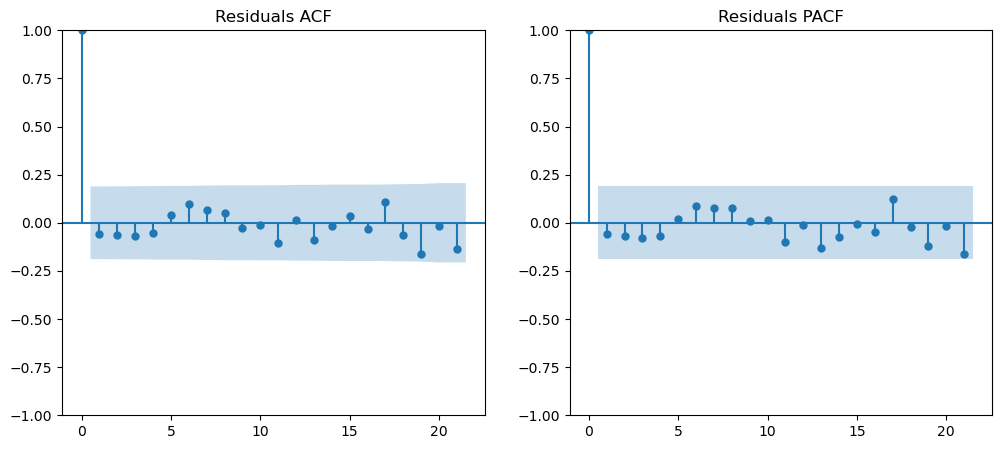

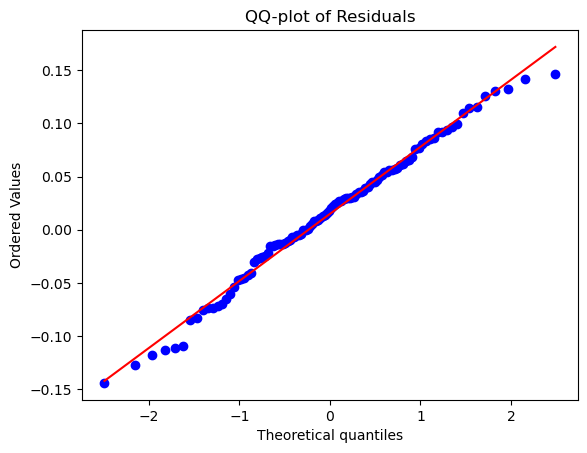

In [635]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(basefit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(basefit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(basefit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [636]:
mscimodel = SARIMAX(y, X_msci, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
mscifit = mscimodel.fit(disp=False, maxiter = 300)
mscifit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                  108
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 145.092
Date:                Thu, 25 Apr 2024   AIC                           -282.184
Time:                        12:22:18   BIC                           -271.456
Sample:                    02-01-2012   HQIC                          -277.834
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
msci_lag1     -0.0619      0.038     -1.648      0.099      -0.136       0.012
ar.L1         -0.4108      0.265     -1.552      0.121      -0.930       0.108
ma.L1          0.6418      0.230      2.787      0.005       0.190       1.093
sigma2         0.0040      0.001      6.603      0.000       0.003       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):                 1.31
Prob(Q):                              0.49   Prob(JB):                         0.52
Heteroskedasticity (H):               1.92   Skew:                            -0.26
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [637]:
acorr_ljungbox(mscifit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,3.86825,0.953095


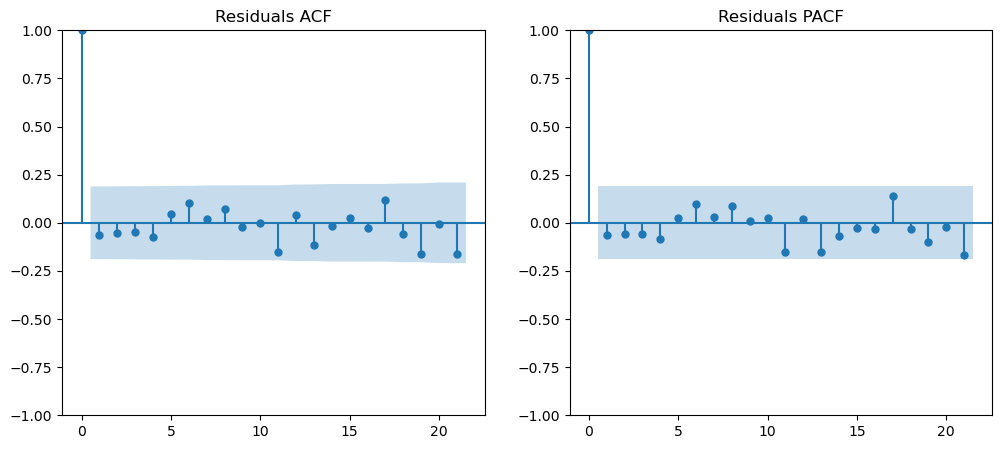

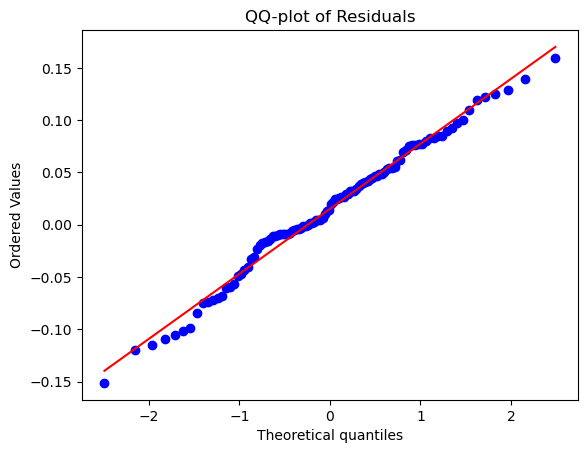

In [638]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(mscifit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(mscifit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(mscifit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [639]:
sentmodel = SARIMAX(y, X_sent, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
sentfit = sentmodel.fit(disp=False, maxiter = 300)
sentfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                  108
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 144.125
Date:                Thu, 25 Apr 2024   AIC                           -280.250
Time:                        12:22:18   BIC                           -269.522
Sample:                    02-01-2012   HQIC                          -275.900
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
sentiment_lag1    -0.0109      0.015     -0.702      0.483      -0.041       0.019
ar.L1             -0.3727      0.285     -1.308      0.191      -0.931       0.186
ma.L1              0.6036      0.255      2.365      0.018       0.103       1.104
sigma2             0.0041      0.001      6.478      0.000       0.003       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):                 1.44
Prob(Q):                              0.55   Prob(JB):                         0.49
Heteroskedasticity (H):               1.81   Skew:                            -0.26
Prob(H) (two-sided):                  0.08   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [640]:
acorr_ljungbox(sentfit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,4.567764,0.918122


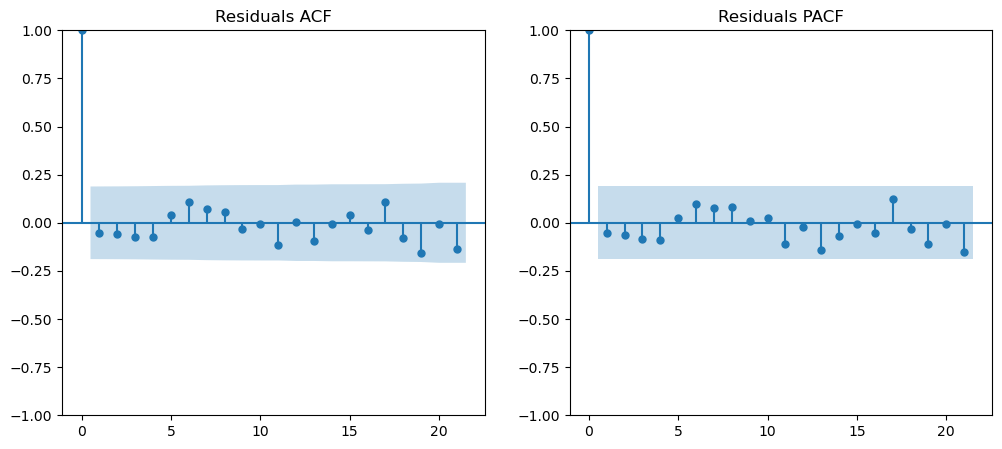

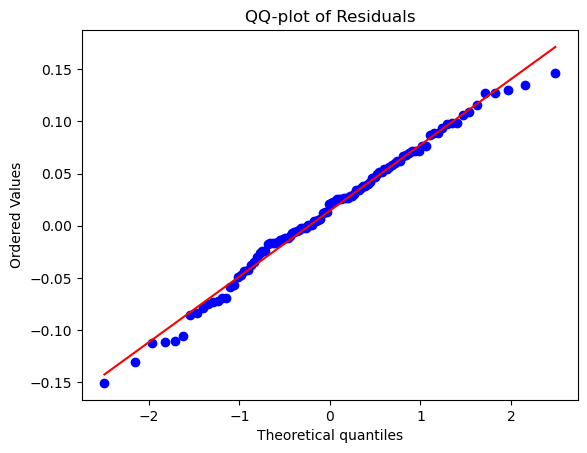

In [641]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(sentfit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(sentfit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(sentfit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [642]:
bothmodel = SARIMAX(y, X_both, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
bothfit = bothmodel.fit(disp=False, maxiter = 300)
bothfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                  108
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 145.275
Date:                Thu, 25 Apr 2024   AIC                           -280.549
Time:                        12:22:19   BIC                           -267.139
Sample:                    02-01-2012   HQIC                          -275.112
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
msci_lag1         -0.0601      0.037     -1.609      0.108      -0.133       0.013
sentiment_lag1    -0.0090      0.015     -0.585      0.559      -0.039       0.021
ar.L1             -0.4090      0.280     -1.462      0.144      -0.957       0.139
ma.L1              0.6355      0.245      2.597      0.009       0.156       1.115
sigma2             0.0040      0.001      6.538      0.000       0.003       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):                 1.47
Prob(Q):                              0.52   Prob(JB):                         0.48
Heteroskedasticity (H):               1.82   Skew:                            -0.28
Prob(H) (two-sided):                  0.08   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [643]:
acorr_ljungbox(bothfit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,4.399536,0.927529


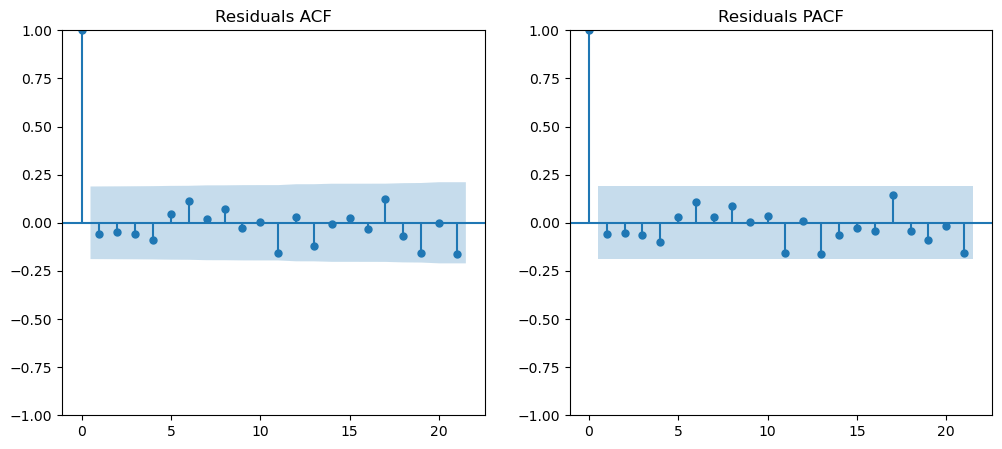

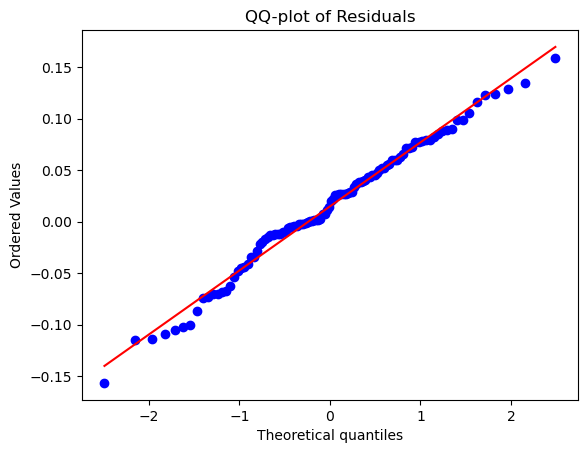

In [644]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(bothfit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(bothfit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(bothfit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

Indeed, the identified best performing models seem to fit the log return series well. In the next section, we will compare their fit based on their out-of-sample performance. Finally, their accuracy in predicting the correct return sign will be assessed.

In [645]:
pbase = basefit.get_forecast(steps=len(ytest), exog=None).predicted_mean
pmsci = mscifit.get_forecast(steps=len(ytest), exog=Xmsci_test).predicted_mean
psent = sentfit.get_forecast(steps=len(ytest), exog=Xsent_test).predicted_mean
pboth = bothfit.get_forecast(steps=len(ytest), exog=Xboth_test).predicted_mean

errors = {
    'Model': ['Base', 'MSCI', 'Sentiment', 'Both'],
    'MAPE': [mape(ytest, pbase), mape(ytest, pmsci), mape(ytest, psent), mape(ytest, pboth)],
    'RMSE': [rmse(ytest, pbase), rmse(ytest, pmsci), rmse(ytest, psent), rmse(ytest, pboth)]
}

results_df = pd.DataFrame(errors)
print(results_df)

       Model       MAPE      RMSE
0       Base  93.451908  0.084214
1       MSCI  96.392136  0.089664
2  Sentiment  86.863337  0.084532
3       Both  96.752158  0.089775


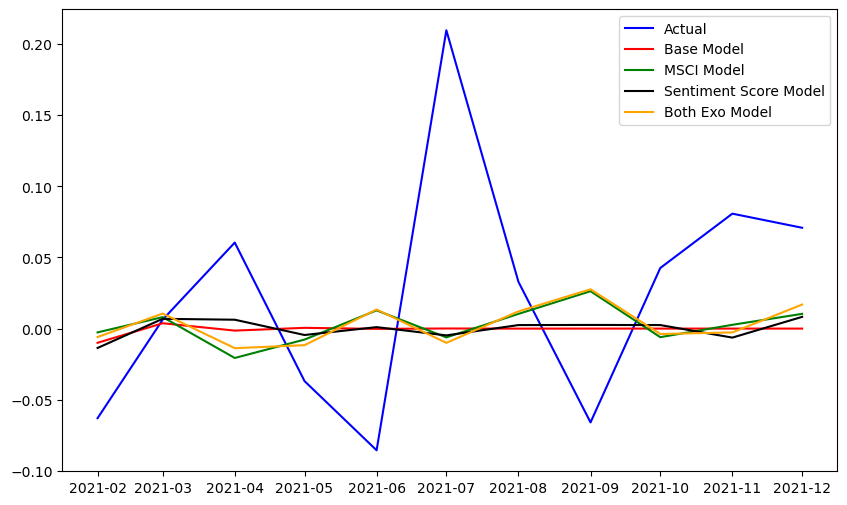

In [646]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, ytest, label='Actual', color='blue')
plt.plot(test.index, pbase, label='Base Model', color='red')
plt.plot(test.index, pmsci, label='MSCI Model', color='green')
plt.plot(test.index, psent, label='Sentiment Score Model', color='black')
plt.plot(test.index, pboth, label='Both Exo Model', color='orange')
plt.legend()

In [647]:
portfolio = pd.read_csv("./tsdata/portfolio.csv", index_col='Date', parse_dates=True)
df.index.freq = "MS"
log_returns = np.log(portfolio["0"] / portfolio["0"].shift(1)).dropna()


predictions = pd.DataFrame()
predictions["Actual"] = log_returns[starttest:endtest].values
predictions["Base"]= pbase.values
predictions["Msci"]= pmsci.values
predictions["Sent"]= psent.values
predictions["Both"]= pboth.values

sign_comparison = predictions[['Base', 'Msci', 'Sent', 'Both']].apply(lambda x: x * predictions['Actual'] > 0)
summary_table = sign_comparison.sum().to_frame(name='Count of True')
summary_table['Percentage of True'] = (sign_comparison.mean() * 100).round(2).astype(str) + '%'

print("Sign Comparison Table:")
print(sign_comparison)
print("\nSummary Table:")
print(summary_table)

Sign Comparison Table:
     Base   Msci   Sent   Both
0    True   True   True   True
1    True   True   True   True
2   False  False   True  False
3   False   True   True   True
4    True  False  False  False
5    True  False  False  False
6   False   True   True   True
7   False  False  False  False
8   False  False   True  False
9    True   True  False  False
10  False   True   True   True

Summary Table:
      Count of True Percentage of True
Base              5             45.45%
Msci              6             54.55%
Sent              7             63.64%
Both              5             45.45%


As can be seen from the results, the model with our own sentiment score performs best in terms of RMSE, predicting the correct return sign more than 50% of the time. This is not the case for any of the other specifications. In conclusion, our proprietary sentiment score seems to contain information that can be used to exploit violations of the efficient market hypothesis. As proven, our sentiment score entails more information than conventional sentiment indices. Given this, one can assume that the sentiment score might improve phone sales prediction themselves.
